# Hyperoptimization of WaveNet for GefCOM2014

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import deep4cast.models as models
import deep4cast.cv as cv

from deep4cast.forecasters import Forecaster
from deep4cast.cv import FoldGenerator, VectorScaler, MetricsEvaluator, CrossValidator
from skopt.space import Real, Integer, Categorical

%matplotlib inline

Using TensorFlow backend.
/Users/toby/anaconda3/envs/deep_forecast/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.23) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


# Parameters

In [2]:
horizon = 7*24
lag = 2*horizon
filters=64
num_layers=2
lr=0.001
epochs=1
test_fraction = 0.1
n_folds=2

# Load the data from file
df = pd.read_pickle('../data/processed/gefcom2014-e.pkl')
df = df[-5000:]

# Data exploration

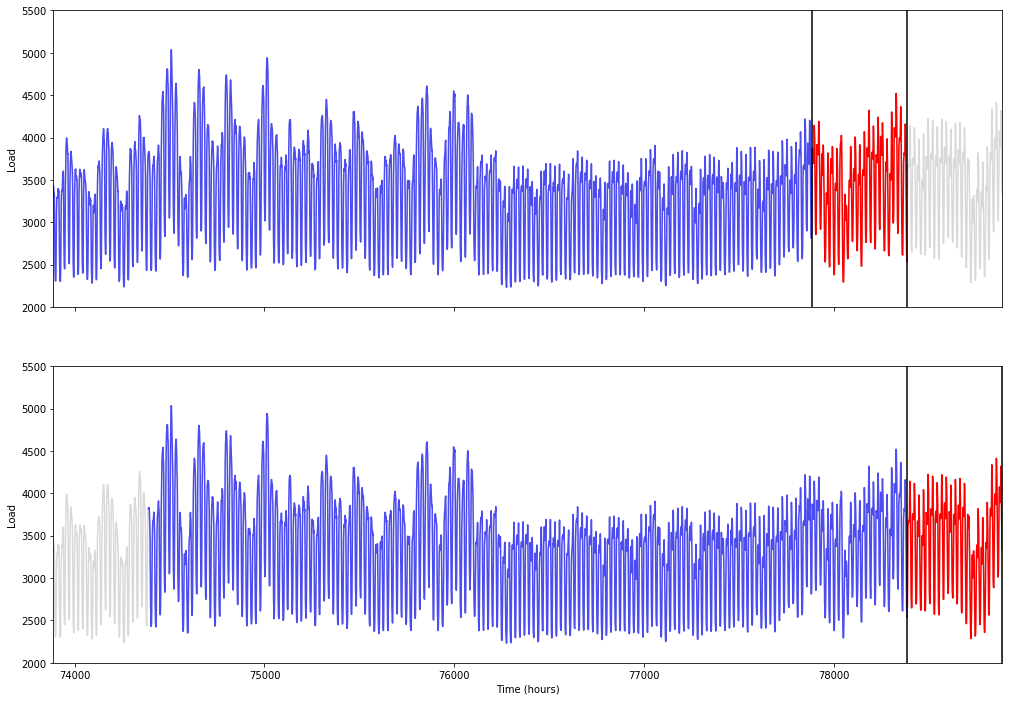

Training fraction: 0.8
Testing fraction: 0.1
Training data points: 4000
Testing data points: 500


<Figure size 432x288 with 0 Axes>

In [3]:
# Let plot the target time series data folds that will be used for temporal cross-validation
test_length = int(len(df)*test_fraction)
train_length = len(df) - n_folds*test_length

fig, axes = plt.subplots(nrows=n_folds, ncols=1, sharex=True, figsize=(17, 12))
for ax, i in zip(axes.flat, range(n_folds)):
    x_train = df.index[i*test_length:i*test_length+train_length]
    y_train = df.load[i*test_length:i*test_length+train_length]
    x_test = df.index[i*test_length+train_length:(i+1)*test_length+train_length]
    y_test = df.load[i*test_length+train_length:(i+1)*test_length+train_length]
    x_all = df.index
    y_all = df.load
    ax.plot(x_all, y_all, 'k-', alpha=0.15)
    ax.plot(x_train, y_train, 'b-', alpha=0.65)
    ax.plot(x_test, y_test, 'r-')
    ax.plot([min(x_test), min(x_test)], [2000, 5500], 'k-')
    ax.plot([max(x_test), max(x_test)], [2000, 5500], 'k-')
    ax.set_ylim([2000, 5500])
    ax.set_xlim([min(x_all), max(x_all)])
    ax.set_ylabel('Load')
plt.xlabel('Time (hours)')
plt.show()
plt.tight_layout()

# Print the number of training, validation, and testing time steps
print(
    'Training fraction: {}\nTesting fraction: {}\nTraining data points: {}\nTesting data points: {}'.format(
    round((1-n_folds*test_fraction), 3), 
    round(test_fraction, 3),
    int(len(df)*(1-n_folds*test_fraction)), 
    int(len(df)*test_fraction)
))

# Data preparation

In [4]:
# Dropping unncecessary columns
data = df.drop(['month', 'day', 'hour'], axis=1)
data = data.dropna()

# We have real-valued and categorial features and we need to make sure that we do the data 
# preparation for them correctly
real_values = ['load', 'temperature']
categorical = list(set(data.columns).difference(set(real_values)))

# Let's create lagged real features to include information about past year's behavior
lagged = data[real_values].shift(365*24-horizon)
lagged = lagged.rename(columns={column:column + '_yearly_lagged' for column in lagged.columns})
data = pd.concat([data, lagged], axis=1)
data = data.dropna()
data = data.reset_index(drop=True)

# Let's shift the holidays back by the horizon length for better forecasting on holidays
data['holiday'] = data['holiday'].shift(-horizon)

# Create a numpy array drop date columns
data_arr = data.drop(['time'], axis=1)
data_arr = np.expand_dims(data_arr.values, 0)

# Model

In [5]:
# Forecaster and model setup
model = models.WaveNet(filters=filters, num_layers=num_layers)
forecaster = Forecaster(model, lag=lag, horizon=horizon, lr=lr, epochs=epochs)

# Fold generator
fold_generator = FoldGenerator(
    data=data_arr, 
    targets=[0], 
    lag=lag, 
    horizon=horizon, 
    test_fraction=test_fraction, 
    n_folds=n_folds
)

# Evaluator
evaluator = MetricsEvaluator(metrics = ['smape', 'pinball_loss', 'coverage'])

# Data scaler
#scaler = VectorScaler(targets = [0, 1])
scaler = VectorScaler(targets = [0, 1, -2, -1])

# Cross-validator
validator = CrossValidator(forecaster, fold_generator, evaluator, scaler)

# Cross Validation

In [6]:
# Evaluate on the cross-validation folds
metrics = validator.evaluate(verbose=True)

IndexError: index -336 is out of bounds for axis 0 with size 0

# Evaluation

In [ ]:
# Let's look at the cross-validation results
print(metrics)

# Plot probability calibration plots
x = [1, 5, 25, 50, 75, 95, 99]
coverages = metrics.iloc[:-2,-7:]
plt.figure(figsize=(6, 6))
plt.plot([0] + x + [100], [0] + x + [100], 'k-', linewidth=3)
for cov_x, cov_y in metrics.coverage:
    plt.plot(cov_x, cov_y, 'o-', alpha=0.2)
plt.legend([''] + ['fold ' + str(s) for s in np.arange(n_folds)])
plt.xlim([0, 100])
plt.ylim([0, 100])
plt.title('Coverage plot')
plt.xlabel('Actual quantile')
plt.ylabel('Prediction quantile')

# Optimization

In [ ]:
space  = [Categorical([32, 64, 128, 256, 512], name='filters'),
          Integer(1, 4, name='num_layers'),
          Integer(24, 4*24, name='lag'),
          Integer(1, 100, name='epochs'),
          Real(10**-6, 10**-3, "log-uniform", name='lr')]

opt_results = validator.optimize(space, 'pinball_loss', n_calls=50)